> Loading modules and libraries

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import json
from glob import glob

pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')


# Libraries for Sentiment Analysis
import nltk
from nltk.corpus import stopwords
import re, string
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


> Reading the data

In [ ]:
# Read the json files using pd.read_json
review = pd.read_json('yelp_academic_dataset_review.json', lines=True)
checkin = pd.read_json('yelp_academic_dataset_checkin.json', lines=True)
tip = pd.read_json('yelp_academic_dataset_tip.json', lines=True)
business = pd.read_json('yelp_academic_dataset_business.json', lines=True)

ValueError: ignored

In [ ]:
# The review data is too large to read in normally, so we will read it in by chunks of 1000 at a time

# Empty list to store each chunk
chunks = [] 

# Specify dtypes 
r_dtypes = {"stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32} 

# Store the json chunks
review = pd.read_json('yyelp_academic_dataset_review.json',
                      lines=True,
                      chunksize=1000,
                      dtype=r_dtypes,
                      orient='records')

# For loop to append each chunk into the chunks list
for chunk in reader:
        reduced_chunk = chunk.drop(columns=['review_id', 'user_id'])\
                             .query("`date` >= '2017-12-01'")
        chunks.append(reduced_chunk)

# Concatenate each chunk into a single dataframe        
reviews = pd.concat(chunks, ignore_index=True)

In [ ]:
print('Size of Business DataFrame: ',business.shape)
print('Size of Reviews DataFrame: ',reviews.shape)

In [ ]:
print('Number of Unique Businesses in Review Data: ',reviews['business_id'].nunique())
print('Number of Unique Businesses in Business Data: ',business['business_id'].nunique())

> Exploring questions

Business

1. Can we get a count of the unique business categories?
2. Count for the number of each star type (5 stars, 4 stars, etc.)
3. Count for the number of businesses that are opened vs closed, grouped by stars and/or number of reviews
4. What are the number of businesses in each state (top 15)

- Review </br>
5. Can we perform a sentiment analysis on the text of the reviews?

> Getting Business Categories

In [ ]:
business_cats=', '.join(business['categories'].dropna())
cats=pd.DataFrame(business_cats.split(', '),columns=['category'])
cats_ser = cats.category.value_counts()
cats_df = pd.DataFrame(cats_ser)
cats_df.reset_index(inplace=True)

In [ ]:
plt.figure(figsize=(12,10))
ax = sns.barplot( y= 'index',x = 'category' , data = cats_df.iloc[0:20])
ax.set_ylabel('Category')
ax.set_xlabel('Number of businesses')
ax.set_title('Number of Business under a Category Type')



for p in ax.patches:
    ax.annotate(int(p.get_width()),
                ((p.get_x() + p.get_width()),
                 p.get_y()),
                 xytext=(1, -18),
                fontsize=12,
                color='#004d00',
                textcoords='offset points',
                horizontalalignment='right')   
plt.show()

> Number of Stars

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.countplot( x='stars' , data = business, palette='PRGn')
ax.set_ylabel('Count')
ax.set_xlabel('Stars')
ax.set_title('Number of Businesses for each Star Rating')

for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-.4, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center') 
                
plt.show()

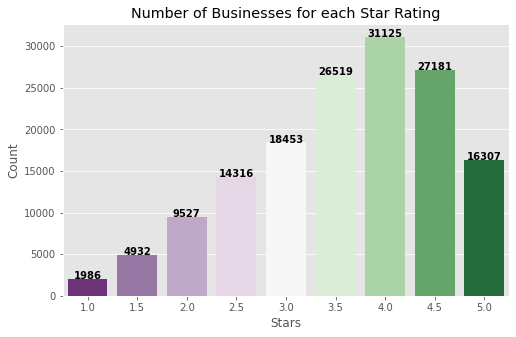

> Counting Open vs Closed businesses

In [ ]:
business['is_open'].value_counts()

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.countplot(hue='stars', x='is_open'  , data = business, palette='Paired')
ax.set_ylabel('Count')
ax.set_xlabel('Is Open')
ax.set_title('Number of Open/Closed Businesses by Star Rating')


num_open , num_closed = business['is_open'].value_counts()

ax.text(-0.3, 23000,
        '(1) Number of Businesses Open: {:.0f}'.format(num_open),
        weight='bold',
        color='blue',
        size='large')

ax.text(-0.3, 22000,
        '(0) Number of Businesses Closed: {:.0f}'.format(num_closed),
        weight='bold',
        color='red',
        size='large')



for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-.05, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
                size='small') 
                
plt.show()

> Businesses in each state

In [ ]:
top15 = business['state'].value_counts(ascending=True).tail(15).to_frame()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=top15.index,y='state', data=top15, palette='RdPu')
ax.set_ylabel('Count')
ax.set_xlabel('States')
ax.set_title('Number of Businesses on Yelp by State (Top 15)')

for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-.4, 
                y+height+2,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
               size='small') 
                
plt.show()

Text Analysis on the reviews

In [ ]:
# Recode 1,2, and 3 stars as 0 (negative review)
# Recode 4 and 5 stars as 1 (positive review)

reviews['sentiment']=reviews['stars'].replace({1:0,2:0,3:0,4:1,5:1})
reviews['sentiment'] = reviews['sentiment'].astype(int)

# Since this dataset is so large, we will work with a random sample of 100,000 reviews
reviews_subset = reviews.sample(100000).reset_index(drop=True)

# Subset of the columns of interest
df = reviews_subset[['text','sentiment']]
df.head()

In [ ]:
# Convert strings to lowercase
df['pre_process'] = df['text'].apply(lambda x:' '.join(x.lower() for x in str(x).split()))

# Convert contractions into separate words (won't = will not)
def contractions(s):
     s = re.sub(r"won’t", "will not",s)
     s = re.sub(r"would’t", "would not",s)
     s = re.sub(r"could’t", "could not",s)
     s = re.sub(r"\’d",  " would",s)
     s = re.sub(r"can\’t", "can not",s)
     s = re.sub(r"n\’t", " not", s)
     s= re.sub(r"\’re", " are", s)
     s = re.sub(r"\’s", " is", s)
     s = re.sub(r"\’ll", " will", s)
     s = re.sub(r"\’t", " not", s)
     s = re.sub(r"\’ve", " have", s)
     s = re.sub(r"\’m", " am", s)
     return s
df['pre_process']=df['pre_process'].apply(lambda x:contractions(x))

# Remove non-alpha characters
df['pre_process']=df['pre_process'].apply(lambda x: ' '.join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))

# Remove extra spaces between words
df['pre_process']=df['pre_process'].apply(lambda x: re.sub(' +', ' ', x))

# Remove stop words
stop = stopwords.words("english")
df['pre_process']=df['pre_process'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['pre_process']=df['pre_process'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

In [ ]:
X = df['pre_process']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train: ",X_train.shape,y_train.shape,"Test: ",(X_test.shape,y_test.shape))

In [ ]:
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

In [ ]:
clf = LinearSVC(random_state=0)
clf.fit(tf_x_train,y_train)
y_test_pred=clf.predict(tf_x_test)
report=classification_report(y_test, y_test_pred,output_dict=True)

In [ ]:
pd.DataFrame(report)

> Evaluating model

- Positive Review

In [ ]:
positive_review = df['pre_process'][43]
positive_review = [positive_review]

pos_review_transformed = vectorizer.transform(positive_review)
pos_review_pred = clf.predict(pos_review_transformed)

print(pos_review_pred)

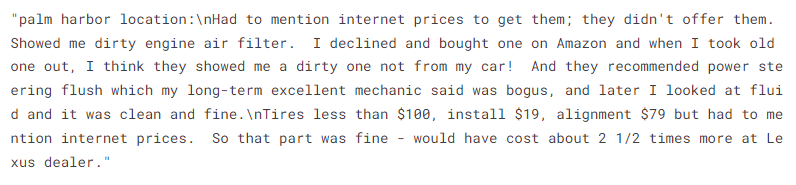

- Negative Review

In [ ]:
negative_review = df['pre_process'][65]
negative_review = [negative_review]

neg_review_transformed = vectorizer.transform(negative_review)
neg_review_pred = clf.predict(neg_review_transformed)

print(neg_review_pred)

> Custom Reviews

In [ ]:
cus_pos_review = 'Blown away by almost every dish. The freshness of the herbs and vegetables, the tenderness of the duck and steak, the complex spices and of the shan tofu and salads! Not your typical southeast Asian restaurant. Definitely a little bit of a twist, but it works well. We tried all the main entrees and a few appetizers, but the standouts were the shan tofu, ribeye done medium rare (you must dip it in the sauce), crispy trout, and beef stir fry. Salads are bright and refreshing. The lighting and decor is sleek and beautiful, service kind and helpful. A bit of a splurge depending on how you order, but what an experience!'
cus_neg_review = "I have dined in a multitude of culinary institutes and Michelin star restaurants not only in the US but abroad as well. I was never treated the way I was treated here with the 2 disgusting hostesses on the night of June 17 2022. Who also decided to harass us and say 'well are you guys going to order anything?!' as we were waiting for our food patiently for 1 AND A HALF HOURS. I did not a receive an apology for her attitude or assumptions nor an apology for the constant glares I was receiving. Very classless and disgusting. Despite the food being good, I will never come back nor recommend this place to friends. I felt very uncomfortable, harassed and UNWANTED like I did not belong there. I did not want to eat anymore. Please re evaluate your hostesses as they're ruining the authentic cultural experience that the owners are trying to portray."
cus_neu_review = "Great cocktails great vibe, beautiful patio. Very average food for a price. Ok service not super attending. Not family friendly or at least our server wasn't accommodating our son in a best way. We won't be back, but check out on your own"

In [ ]:
cus_pos_review = [cus_pos_review]

cus_pos_review_transformed = vectorizer.transform(cus_pos_review)
cus_pos_review_pred = clf.predict(cus_pos_review_transformed)

print(cus_pos_review_pred)

In [ ]:
cus_neg_review = [cus_neg_review]

cus_neg_review_transformed = vectorizer.transform(cus_neg_review)
cus_neg_review_pred = clf.predict(cus_neg_review_transformed)

print(cus_neg_review_pred)

In [ ]:
cus_neu_review = [cus_neu_review]

cus_neu_review_transformed = vectorizer.transform(cus_neu_review)
cus_neu_review_pred = clf.predict(cus_neu_review_transformed)

print(cus_neu_review_pred)

> Results:

- Our model has a prediction accuracy of 92%
- The model is slightly better at predicting postive reviews (93%) as opposed to negative reivews (89%)
- The model was able to accurately predict the sentiment for 2 random reviews chosen from the data (1 positive and 1 negative)
- The model was able to accurately predict the sentiment for 2 custom reviews
- NB: When a neutral review was put through the model it predicts it as positive.

It is to be expected that the model will get confused with neutral (3 star) reviews. It may be more appropriate to change this to multi-class classification where we regroup the star ratings to have positive, negative, AND neutral.
